# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model; compute_MAP=true);

In [8]:
spl = MCHMC(varE_wanted=1.0) #MCHMC(0.03125, 0.6145; varE_wanted=2.0)

MicroCanonicalHMC.Sampler(Settings(Random.MersenneTwister(0), 1.0, 0, 1000, 10, "LF"), Hyperparameters(0.0, 0.0, 0.0, 0.1931833275037836, [0.0]), MicroCanonicalHMC.Leapfrog)

In [9]:
samples_mchmc = Sample(spl, target, 100000;
                       monitor_energy=true, 
                       dialog=true);

[ Info: Tuning sigma ⏳
[ Info: Found sigma: [0.45043479852950286, 0.060888704437465316] ✅
[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 0.6909124353954109


[ Info: Found eps: 0.5 ✅
[ Info: Tuning L ⏳


samples: 100--> ESS: 0.08769789762289978
samples: 243--> ESS: 0.09214756525947825


[ Info: Found L: 2.170431735627742 ✅


In [10]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

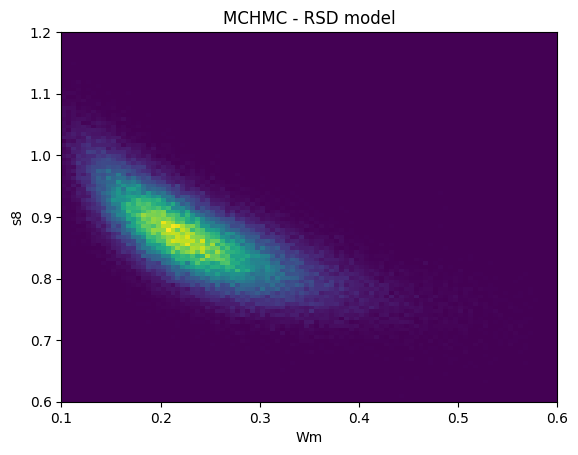

In [11]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [57]:
nchains = 100
e_spl = MCHMC(0.2, 0.0, nchains; varE_wanted = 2.0)# sigma=[1.0, 1.0]) #sigma=[0.45043479852961416, 0.060888704437565826])
#e_spl = MCHMC(0.0, 0.0, nchains; sigma=[1.0, 1.0])

MicroCanonicalHMC.EnsembleSampler(MicroCanonicalHMC.EnsembleSettings(100, Random.MersenneTwister(0), 2, 2.0, 10, 10, "LF"), Hyperparameters(0.2, 0.0, 0.0, 0.1931833275037836, [0.0]), MicroCanonicalHMC.Leapfrog)

In [58]:
samples_ensemble_mchmc = Sample(e_spl, target, 1000, 100;
   monitor_energy=true, 
   dialog=false);

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented using L = sqrt(target.d)
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:25
[ Info: Virial loss condition met during burn-in at step: 16


In [59]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

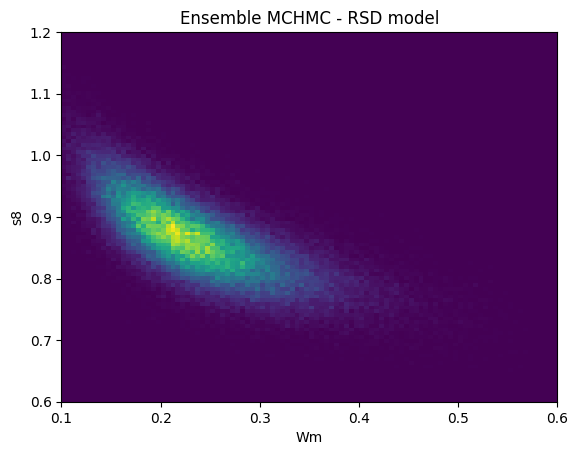

In [60]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

## AbstractMCMC

In [16]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

eps: 0.5 --> VarE: 0.5345866305843806
samples: 100--> ESS: 0.22647457709943417


[ Info: Tuning sigma ⏳
[ Info: Found sigma: [0.4504347985295386, 0.06088870443747062] ✅
[ Info: Tuning eps ⏳
[ Info: Found eps: 0.5 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 0.8831013289062886 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.94 seconds
Compute duration  = 1.94 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2404    0.0672     0.0007    0.0029   448.9601    0.9999     ⋯
          σ8    0.8627    0.0614     0.0006    0.0026   474.5861    0.9999     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1330    0.1920    0.2320    0.2804    0.3945
          σ8    0.7522    0.8203    0.8586    0.9014    0.9942


In [17]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.62 seconds
Compute duration  = 0.62 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2331    0.0634     0.0006    0.0027   532.7785    1.0007     ⋯
          σ8    0.8681    0.0607     0.0006    0.0024   603.7450    1.0001     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1304    0.1866    0.2260    0.2708    0.3746
          σ8    0.7613    0.8246    0.8644    0.9072    0.9962


## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

eps: 0.5 --> VarE: 1.1574477684874251
samples: 100--> ESS: 0.24132371077780798


[ Info: Tuning sigma ⏳
[ Info: Found sigma: [0.4504347985299103, 0.06088870443745691] ✅
[ Info: Tuning eps ⏳
[ Info: Found eps: 0.5 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 0.8287623265670085 ✅
chain 3:   2%|█                                         |  ETA: 0:00:04chain 2:   2%|█                                         |  ETA: 0:00:04
chain 4:   4%|█▋                                        |  ETA: 0:00:03
chain 1:   4%|█▋                                        |  ETA: 0:00:03

chain 2:   8%|███▏                                      |  ETA: 0:00:02
chain 4:  10%|████                                      |  ETA: 0:00:02
chain 3:   8%|███▏                                      |  ETA: 0:00:03
chain 1:  10%|████▎                                     |  ETA: 0:00:02
chain 2:  12%|█████▎                                    |  ETA: 0:00:02
chain 4:  15%|██████▎                                   |  ETA: 0:00:02
chain 3:  14%|█████▋                                    |  ETA: 0:00:02
chain 1:  16%|███

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run
chain 2:   5%|██▏                                       |  ETA: 0:00:02



























chain 3:  10%|████▍                                     |  ETA: 0:00:02
chain 4:  10%|████▍                                     |  ETA: 0:00:02

chain 1:  10%|████▍                                     |  ETA: 0:00:02
chain 2:  10%|████▍                                     |  ETA: 0:00:02
chain 4:  16%|██████▉                                   |  ETA: 0:00:02
chain 3:  17%|███████▏                                  |  ETA: 0:00:01

chain 1:  16%|██████▊                                   |  ETA: 0:00:02
chain 2:  16%|██████▊                                   |  ETA: 0:00:02
chain 4:  22%|█████████▌                                |  ETA: 0:00:01
chain 3:  23%|█████████▋                                |  ETA: 0:00:01
chain 1:  21%|████████▉                                 |  ETA: 0:00:02
chain 2:  21%|████████▉                                 |  ETA: 0:00:02


4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 9.21 seconds
Compute duration  = 9.21 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2400    0.0673     0.0007    0.0017   1519.4229    0.9999    ⋯
          σ8    0.8644    0.0616     0.0006    0.0013   2277.7359    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.216442  0.88862   16.2117  23.0  1.0  …  4.0  0.0  0.0568589  0.0568589
 0.174146  0.860634  15.0557  11.0  1.0     3.0  0.0  0.0568589  0.0568589
 0.159435  0.878645  14.7617   9.0  1.0     3.0  0.0  0.0568589  0.0568589
 0.283127  0.819435  15.9098  15.0  1.0     3.0  0.0  0.0568589  0.0568589
 0.293693  0.804948  15.6947   7.0  1.0     2.0  0.0  0.0568589  0.0568589
 0.257482  0.820709  16.0031  17.0  1.0  …  4.0  0.0  0.0568589  0.0568589
 0.187975  0.954872  15.0502  19.0  1.0     4.0  0.0  0.0568589  0.0568589
 0.180751  0.852851  15.1357   5.0  1.0     2.0  0.0  0.0568589  0.0568589
 0.176183  0.985551  14.1396  15.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

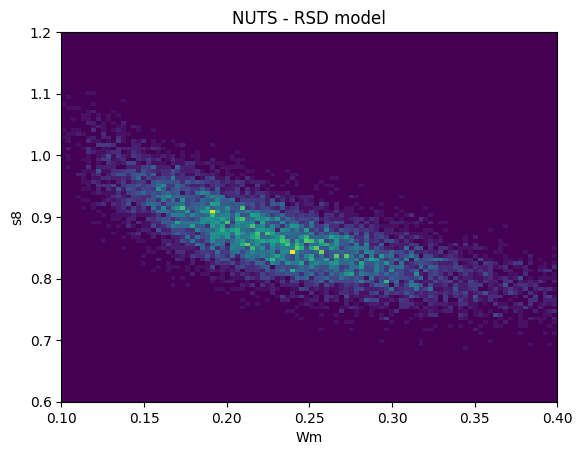

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");